In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.chdir('/content/gdrive/My Drive/Retinopathy/idrid/Detection')
print(os.listdir())

['PreProcessing.ipynb', 'IDRiD_06.jpg', 'equalized_images', 'relative_equalized_images', 'groundtruths', 'cropnblur', 'original_images', 'BB_Plots.ipynb', 'cropnblur_offsets']


# Histogram Equalization

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import cv2
import io
from skimage import exposure
from scipy.ndimage.morphology import binary_fill_holes
import copy

class PPImage:

    def __init__(self, image_path = ""):
        if image_path != "":
            self.open(image_path)

    def from_zip(self, zip_file, file, folder = ''):
        archive = zipfile.ZipFile(zip_file, 'r')
        imgdata = archive.read(folder+file)
        imgdata = io.BytesIO(imgdata)

        self.open(imgdata, True)

    def open(self, path, resize_im=False):
        self.image = Image.open(path)

        if resize_im:
            basewidth = 1000
            img = self.image
            wpercent = (basewidth / float(img.size[0]))
            hsize = int((float(img.size[1]) * float(wpercent)))
            self.image = img.resize((basewidth, hsize))

        self.data = np.array(self.image)
        # self.get_stats()

    def show(self, img = ""):
        if isinstance(img, str): img = self.data
        if len(img.shape) == 2: plt.imshow(img, plt.cm.gray)
        else: plt.imshow(img)
        plt.show()

    def mean_subtract(self):
        pass

    def plot_hist(self):
        ch = self.data.shape[2]

        # fig = plt.figure("Comparison")
        for i in range(ch):
            dt = self.data[:,:,i]
            # ax = fig.add_subplot(ch, 1, i+1)
            plt.hist(dt, bins=10)
            plt.show()

    def export(self, path, img='', quality='avg'):
        if isinstance(img, str): img = self.data
        if quality == 'good':
            Image.fromarray(img).save(path, subsampling=0, quality=100)
        else: Image.fromarray(img).save(path)

    def grayscale(self, img='', type='avg'):
        if isinstance(img, str): img = self.data
        if type =='max':
            return np.max(img, axis=2)
        else:
            return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    def thresh(self, thresh=20):
        gray = cv2.cvtColor(np.array(self.image), cv2.COLOR_RGB2GRAY)
        black_loc = gray < thresh
        self.data[black_loc] = 0

    def pad(self):
        self.data = cv2.copyMakeBorder(self.data, 350, 350, 350, 350, cv2.BORDER_CONSTANT, value=0)

    def white_balance(self, img):
        result = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        avg_a = np.average(result[:, :, 1])
        avg_b = np.average(result[:, :, 2])
        result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)
        result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)
        return cv2.cvtColor(result, cv2.COLOR_LAB2BGR)

    def compare(self, img1 = None, img2 = None):
        if (img1 is None): img1 = np.array(self.image)
        if (img2 is None): img2 = self.data
        fig = plt.figure("Comparison")

        ax = fig.add_subplot(1, 3, 1)
        if len(img1.shape)==2: plt.imshow(np.array(self.image), plt.cm.gray)
        else: plt.imshow(np.array(self.image))

        ax = fig.add_subplot(1, 3, 2)
        if len(img1.shape)==2: plt.imshow(img1, plt.cm.gray)
        else: plt.imshow(img1)

        ax = fig.add_subplot(1, 3, 3)
        if len(img2.shape)==2: plt.imshow(img2, plt.cm.gray)
        else: plt.imshow(img2)


        figManager = plt.get_current_fig_manager()
        figManager.window.showMaximized()
        fig.canvas.draw()
        fig.tight_layout()

        plt.show()

    def get_stats(self):
        ch = self.data.shape[2]
        self.stats = []
        for i in range(ch):
            st = {}
            st['mean'] = np.mean(self.data[:,:,i])
            self.stats.append(st)

    def color_correct(self):
        p2, p98 = np.percentile(self.data, (2, 98))
        self.data = exposure.rescale_intensity(self.data, in_range=(p2, p98))

    def hist_equalize(self, img=''):
        if isinstance(img, str): img = self.data
        img = copy.copy(img)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        ch = img.shape[2]
        for i in range(ch):
            img[:, :, i] = clahe.apply(img[:, :, i])
        return img

    def hist_match_rgb(self, target, exclude_backgroud = True, background_tol = 20):
        ch = self.data.shape[2]
        thresh = -1
        if exclude_backgroud:
            thresh = background_tol

        source_bin = self.binary(self.data, thresh)
        source_targ = self.binary(target, thresh)
        # self.compare(source_bin, source_targ)


        for i in range(ch):
            source = self.data[:,:,i][source_bin > 0]
            template = target[:,:, i][source_targ > 0]
            oldshape = source.shape
            source = source.ravel()
            template = template.ravel()

            # get the set of unique pixel values and their corresponding indices and
            # counts
            s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                                    return_counts=True)
            t_values, t_counts = np.unique(template, return_counts=True)

            # take the cumsum of the counts and normalize by the number of pixels to
            # get the empirical cumulative distribution functions for the source and
            # template images (maps pixel value --> quantile)
            s_quantiles = np.cumsum(s_counts).astype(np.float64)
            s_quantiles /= s_quantiles[-1]
            t_quantiles = np.cumsum(t_counts).astype(np.float64)
            t_quantiles /= t_quantiles[-1]

            # interpolate linearly to find the pixel values in the template image
            # that correspond most closely to the quantiles in the source image
            interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)
            self.data[:, :, i][source_bin > 0] = interp_t_values[bin_idx].reshape(oldshape)
        print()

    def crop_image_only_outside(self, img, mask_im='', tol=10):
        # img is 2D or 3D image data
        # tol  is tolerance
        bin = self.binary(img, tol=tol)
        # bin = cv2.cvtColor(bin, cv2.COLOR_GRAY2RGB)
        col = bin < tol
        img[col] = 0
        # self.show(bin)
        # exit()
        mask = img > 0
        if img.ndim == 3:
            mask = mask.all(2)
        m, n = mask.shape
        mask0, mask1 = mask.any(0), mask.any(1)
        col_start, col_end = mask0.argmax(), n - mask0[::-1].argmax() - 1
        row_start, row_end = mask1.argmax(), m - mask1[::-1].argmax() - 1
        img = img[row_start:row_end, col_start:col_end]
        if isinstance(mask_im, str) == False:
            mask_im = mask_im[row_start:row_end, col_start:col_end]
            return img, mask_im
        else:
            return img


    def binary(self, img="", tol=15):
        if isinstance(img, str): img = self.data
        gray = self.grayscale(img, type='max')
        gray[gray < tol] = 0
        gray[gray > tol] = 255
        gray = binary_fill_holes(gray).astype(np.uint8)*255
        return gray

    def resize(self, img="", dim=""):
        if isinstance(img, str): img = self.data
        if isinstance(dim, str):
            return img
        new_im = np.array(Image.fromarray(img).resize(dim))
        return new_im


IDRiD_80.jpg



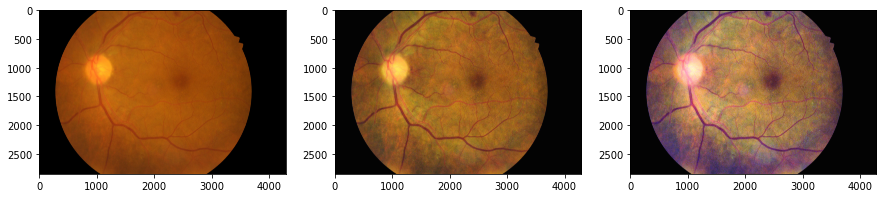

IDRiD_81.jpg



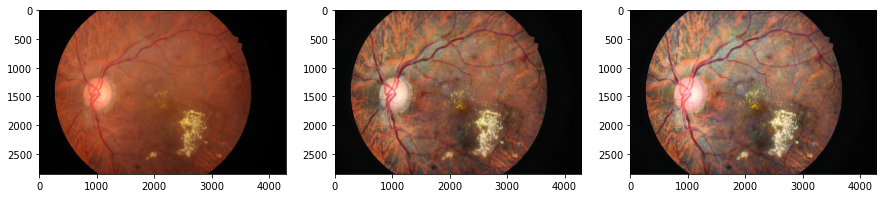

IDRiD_76.jpg



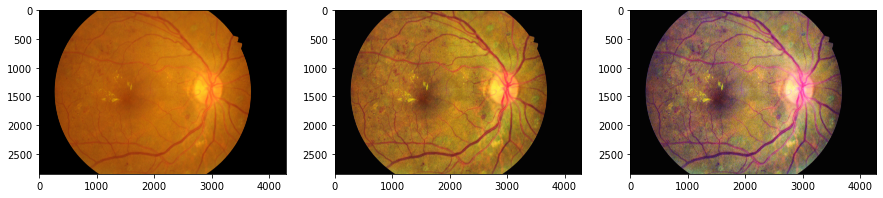

IDRiD_79.jpg



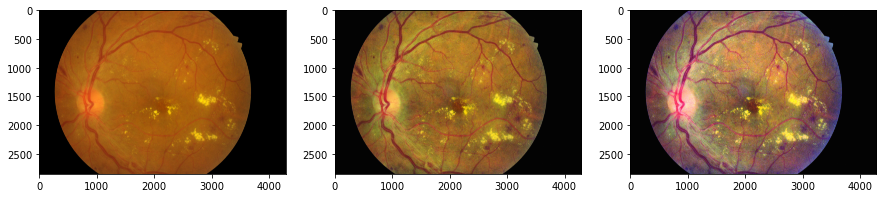

IDRiD_57.jpg



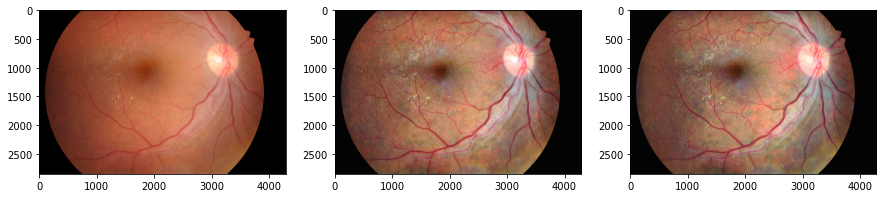

In [ ]:
target = PPImage('IDRiD_06.jpg')

src_dir = 'original_images/test'

samples = 5

for i, im in enumerate(os.listdir(src_dir)[:samples]):
    print(im)
    img = PPImage(os.path.join(src_dir, im))

    f, ax = plt.subplots(1,3,figsize = (15,15))
    ax[0].imshow(img.data)

    histEq = img.hist_equalize(img.data)
    target.data = target.resize(dim=(img.data.shape[1], img.data.shape[0]))
    img.hist_match_rgb(target=target.data)
    img.data = img.hist_equalize(img.data)

    ax[1].imshow(histEq)
    ax[2].imshow(img.data)

    plt.show()

## Saving to Disk

In [ ]:
target = PPImage('IDRiD_06.jpg')

src_dir = 'original_images/test'
eq_dir = 'equalized_images/test'
rel_eq_dir = 'relative_equalized_images/test'
os.makedirs(eq_dir, exist_ok=True)
os.makedirs(rel_eq_dir, exist_ok=True)

for im in os.listdir(src_dir):
    print(im)
    img = PPImage(os.path.join(src_dir, im))

    histEq = img.hist_equalize(img.data)
    img.export(os.path.join(eq_dir, im), img=histEq, quality='good')

    target.data = target.resize(dim=(img.data.shape[1], img.data.shape[0]))
    img.hist_match_rgb(target=target.data)
    img.data = img.hist_equalize(img.data)
    img.export(os.path.join(rel_eq_dir, im), img='', quality='good')

IDRiD_80.jpg

IDRiD_81.jpg

IDRiD_76.jpg

IDRiD_79.jpg

IDRiD_57.jpg

IDRiD_59.jpg

IDRiD_58.jpg

IDRiD_56.jpg

IDRiD_55.jpg

IDRiD_61.jpg

IDRiD_65.jpg

IDRiD_60.jpg

IDRiD_64.jpg

IDRiD_62.jpg

IDRiD_63.jpg

IDRiD_70.jpg

IDRiD_67.jpg

IDRiD_69.jpg

IDRiD_66.jpg

IDRiD_71.jpg

IDRiD_68.jpg

IDRiD_74.jpg

IDRiD_75.jpg

IDRiD_73.jpg

IDRiD_72.jpg

IDRiD_78.jpg

IDRiD_77.jpg



# Circle Crop + Gaussian Blur

In [5]:
import os
from scipy import ndimage
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [42]:
def crop_image_from_gray(img, tol=10):
    dims = img.ndim

    if dims == 3:
        gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif dims == 2:
        gray_image = img

    mask = gray_image > tol

    # find start crop point
    objs = ndimage.find_objects(mask)
    height_offset = objs[0][0].start
    width_offset = objs[0][1].start

    # plt.imshow(mask, cmap="gray")
    # plt.axvline(x=width_offset)
    # plt.axhline(y=height_offset)
    # plt.show()

    ix = np.ix_(mask.any(1),mask.any(0))

    if dims == 2:
        return img[ix], height_offset, width_offset
    
    check_shape = img[:,:,0][ix].shape[0]
    if (check_shape == 0): # image is too dark so that we crop out everything,
        return img, 0, 0 # return original image

    img1 = img[:,:,0][ix]
    img2 = img[:,:,1][ix]
    img3 = img[:,:,2][ix]
    img = np.stack([img1, img2, img3],axis=-1)

    return img, height_offset, width_offset

In [43]:
def circle_crop(img, sigmaX=50):   
    """
    Create circular crop around image centre    
    """
    img, height_offset, width_offset = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = cv2.addWeighted(img,4, cv2.GaussianBlur(img, (0,0), sigmaX), -4, 128)

    return img, height_offset, width_offset

IDRiD_18.jpg
(2848, 4288, 3)
(2848, 3413, 3)
height_offset 0
width_offset 282



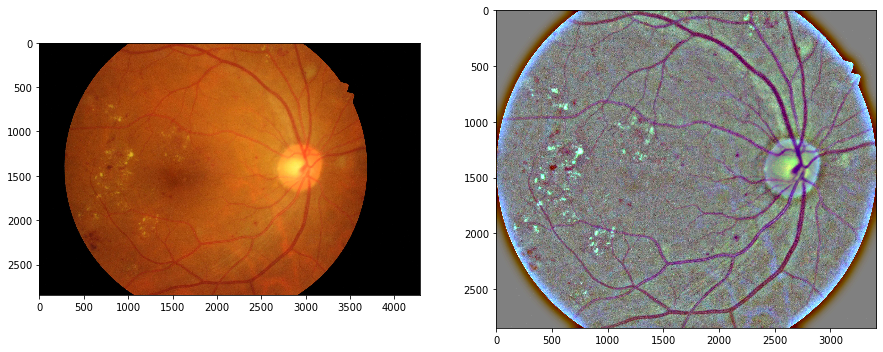

IDRiD_36.jpg
(2848, 4288, 3)
(2848, 3412, 3)
height_offset 0
width_offset 284



KeyboardInterrupt: 

In [44]:
src_dir = 'data/Original Images/train'

samples = 15

for i, im in enumerate(os.listdir(src_dir)[:samples]):
    print(im)
    img = cv2.imread(os.path.join(src_dir, im))
    height, width, depth = img.shape
    img_t, height_offset, width_offset = circle_crop(img, 50)
    print(img.shape)
    print(img_t.shape)
    print("height_offset", height_offset)
    print("width_offset", width_offset)
    print()

    f, axarr = plt.subplots(1,2, figsize=(15,11))
    axarr[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axarr[1].imshow(cv2.cvtColor(img_t, cv2.COLOR_BGR2RGB))
    plt.show()

## Saving to Disk

In [41]:
src_dir = 'data/Original Images/train'
out_dir = 'cropnblur/train'
offsets_dir = 'cropnblur_offsets/train'

os.makedirs(out_dir, exist_ok=True)
os.makedirs(offsets_dir, exist_ok=True)

for im in os.listdir(src_dir):
    print(im)
    img = cv2.imread(os.path.join(src_dir, im))

    height, width, _ = img.shape

    img_t, height_offset, width_offset = circle_crop(img, sigmaX=50)

    cv2.imwrite(os.path.join(out_dir, im), cv2.cvtColor(img_t, cv2.COLOR_RGB2BGR))

    new_height, new_width, _ = img_t.shape

    with open(os.path.join(offsets_dir, im[:-4]+"_offset.txt"), 'w') as f:
        f.write("{} {} {} {} {} {}\n".format(height, width, height_offset, width_offset, new_height, new_width))

IDRiD_18.jpg
IDRiD_36.jpg
IDRiD_01.jpg


KeyboardInterrupt: 